# Neural Network for Titanic Dataset

## Setup

In [75]:
import sys
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Go up one level from the current working directory
parent_directory = os.path.join(current_working_directory, '..')

# Add the parent directory to sys.path
sys.path.append(parent_directory)

os.getcwd()

'/home/sverrnys/Dokumenter/personal_projects/titanic-survival-predictor/models'

In [76]:
%pip install scikit-learn
%pip install tensorflow
%pip install shap
%pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [77]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
%autoreload 2

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from src.ml_service import prepare_data, prepare_test_data, save_predictions
from src.config import TARGET_FEATURE

## Load data

In [79]:
x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(validation_size=0.1, test_size=0.1)


In [80]:
# Get all the rows containing nans

x_train.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives,traveled_alone,FamilySize,Title
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,1.330056,0.655899,29.538225,0.553371,0.379213,32.586276,6.747191,1.564607,0.932584,0.602528,1.254213,1.356742
std,0.824584,0.475408,12.994548,1.176404,0.791669,51.969529,2.441004,0.773168,1.682525,0.489719,0.577335,0.651070
min,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.000000,0.000000,0.000000,7.925000,8.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,2.000000,1.000000,29.699118,0.000000,0.000000,14.454200,8.000000,2.000000,0.000000,1.000000,1.000000,1.000000
75%,2.000000,1.000000,35.000000,1.000000,0.000000,30.500000,8.000000,2.000000,1.000000,1.000000,2.000000,2.000000
max,2.000000,1.000000,80.000000,8.000000,6.000000,512.329200,8.000000,2.000000,10.000000,1.000000,2.000000,5.000000


## Train model



In [81]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks = [early_stopping, reduce_lr]


def build_model(input_shape) -> keras.Sequential:
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[input_shape]), 
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'), 
        layers.Dense(1)  
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

predictor = build_model(x_train.shape[1])

/home/sverrnys/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
history = predictor.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), callbacks=callbacks)


Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4756 - loss: 6.8013 - val_accuracy: 0.6629 - val_loss: 3.9578 - learning_rate: 0.0010
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5858 - loss: 5.5763 - val_accuracy: 0.5730 - val_loss: 6.0557 - learning_rate: 0.0010
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6151 - loss: 5.4363 - val_accuracy: 0.5730 - val_loss: 5.4806 - learning_rate: 0.0010
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6243 - loss: 5.2008 - val_accuracy: 0.6517 - val_loss: 3.8450 - learning_rate: 0.0010
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5808 - loss: 5.5356 - val_accuracy: 0.6742 - val_loss: 3.7947 - learning_rate: 0.0010
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6337 - loss: 4.7982 - val_accuracy: 0.6854 - val_loss: 3.6280 - learning_rate: 0.0010
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6235 - loss: 4.7356 - val_acc

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,173 (59.27 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,116 (39.52 KB)

Weights: [[ 0.00188744  0.2660526   0.271411   -0.10187279 -0.2838394   0.23233184
  -0.03671126 -0.03827478  0.15565242 -0.22702849  0.04038374  0.13199376
   0.19736442  0.23833418  0.12647769  0.14414372 -0.00043907 -0.15847066
   0.12846522  0.26136723  0.02369625 -0.0952     -0.12407651  0.04213145
   0.12310828 -0.22832453  0.09724304  0.20000225  0.08530735 -0.02046266
   0.15502714  0.14347896 -0.18122105  0.23454317  0.08252704  0.13850142
  -0.1884835  -0.1707319   0.24681349  0.21715511 -0.0119629   0.03154738
   0.07854541  0.09554458  0.12925473 -0.14442554  0.02613057 -0.09971552
  -0.00654239  0.27416646  0.2521693  -0.02815086  0.1688562   0.21347755
  -0.08733824  0.03775012 -0.24711409 -0.15055521 -0.11356595 -0.10353727
  -0.21766251  0.04249714  0.24354716  0.13672625]
 [-0.26279616  0.20040615  0.17081869  0.07703155  0.14537561 -0.20955005
  -0.11486678  0.01433983  0.00440212  0.23872975 -0.15985018 -0.1020489
  -0.2731421   0.00346149  0.18732585  0.16683684  0.

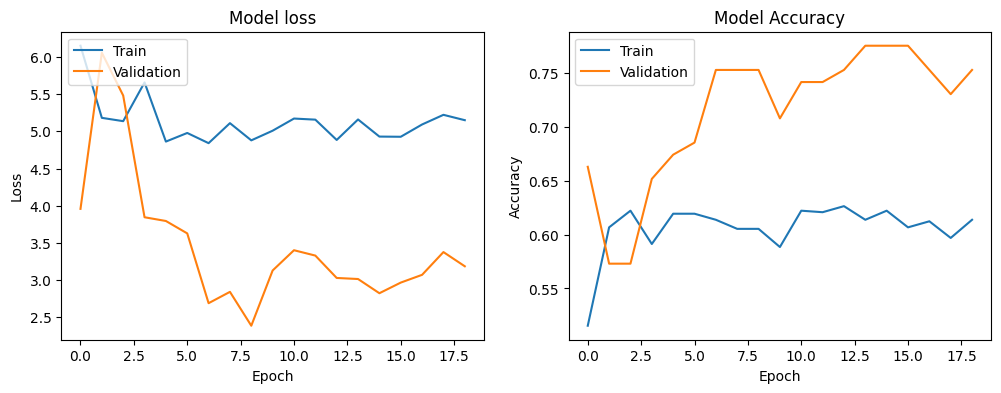

In [83]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import shap

# 1. Model Summary
predictor.summary()


# 2. Visualize the Model
plot_model(predictor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# 3. Extract and Inspect Weights
weights, biases = predictor.layers[0].get_weights()
print("Weights:", weights)
print("Biases:", biases)

# 4 Visualize the Training Process
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### Loading pre-trained model

## Make predictions

In [84]:
# Evaluate on the test set
y_test_pred = predictor.predict(x_test)
y_test_pred_1 = pd.DataFrame(y_test)
y_test_pred_1['Survived'] = y_test_pred
y_test_pred_1['Survived'] = y_test_pred_1['Survived'].apply(lambda x: 1 if x >= 0.5 else 0)
y_test_pred = y_test_pred_1

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: ", test_accuracy)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test Accuracy:  0.7
Test Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77        56
           1       0.63      0.50      0.56        34

    accuracy                           0.70        90
   macro avg       0.68      0.66      0.67        90
weighted avg       0.69      0.70      0.69        90



## Save model

In [85]:
x_final_test = prepare_test_data()
final_predictions = predictor.predict(x_final_test)
final_predictions = pd.DataFrame(final_predictions, columns=[TARGET_FEATURE])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


In [86]:
# Save the final predictions as a CSV file
save_predictions(final_predictions, f'predictions_neural_network')